## **Neuroengineering Workshop 2021** 
### Deep Learning for CT SuperResolution
***
#### Task 3 - Denoising and Increased Resolution
Alberto Rota *10615751*  -  Carlo Andrea Sartori *10588088*  -  Federico Monterosso *10568922*  -  Iva Milojkovic *10775195*
***

### Environment setup and dependency docking

In [ ]:
import os
import sys
import time
import gc
import pickle
import math
from random import shuffle
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils.layer_utils import count_params
import scipy
print(f"Using TensorFlow version: {tf.__version__}")

SEED = 69
tf.random.set_seed(SEED)
print(f"RNG Seed: {SEED}")

tfk = tf.keras
tfkl = tf.keras.layers

Using TensorFlow version: 2.7.0
RNG Seed: 69


Mount the drive folder for accessing the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Colab downloads from drive on the VM only when the data is requested: this slows down a lot the first epoch of training. By zipping the dataset and unzipping it prior to the training phase, we are sure that the data is already on the VM's RAM when training starts

In [ ]:
!unzip /content/drive/MyDrive/superres_data.zip -d /content/superres_dataset



### Referencing the data and setting up dimensions

In [ ]:
ROOT_PATH = '/content/superres_dataset'

# FOLDER TO LOAD DATA FROM
DATA_PATH = os.path.join(ROOT_PATH,'Data')
MODEL_PATH = os.path.join(ROOT_PATH,'Model')

# Volume size
N_ROWS_VOLUME           = 128
N_COLUMNS_VOLUME        = 128
N_SLICES_VOLUME         = 64
NOISE                   = 0.0001 

# Label size
N_ROWS_LABEL            = 256
N_COLUMNS_LABEL         = 256
N_SLICES_LABEL          = 64

# Type
VOLUME_TYPE       = 'nii'

VOLUME_TEMPLATE = os.path.join(DATA_PATH,"VolumeCT_%s_{}_{}_{}_n{}.{}".format(
    N_ROWS_VOLUME,
    N_COLUMNS_VOLUME,
    N_SLICES_VOLUME,
    str(NOISE),
    VOLUME_TYPE
    )
)
LABEL_TEMPLATE = os.path.join(DATA_PATH,"VolumeCT_%s_{}_{}_{}.{}".format(
    N_ROWS_LABEL,
    N_COLUMNS_LABEL,
    N_SLICES_LABEL,
    VOLUME_TYPE
    )
)

# Read available data
AVAILABLE_NUMBER_OF_CASES = 58
try:
    del trainVolumes
    del trainLabels
    del validationVolumes
    del validationLabels
    del testVolumes
    del testLabels
except:
    pass
gc.collect()
volumes_list = []
labels_list = []

for index_case in range(1, AVAILABLE_NUMBER_OF_CASES+1):
    case_id = "{:0>3}".format(index_case)
    volume_path = VOLUME_TEMPLATE % (case_id)
    label_path = LABEL_TEMPLATE % (case_id)
    if (os.path.exists(volume_path) and os.path.exists(label_path)):
        AVAILABLE_NUMBER_OF_CASES += 1
        volumes_list.append(volume_path)
        labels_list.append(label_path)
    else:
        print("Not found")
        print(volume_path)
        print(label_path)

### Train-Validation-Test Splitting

In [ ]:
AVAILABLE_NUMBER_OF_CASES = 58
###############################################################################################
# TRAINING-VALIDATION-TEST PERCENTAGES
TRAINING_PERC_CASES                 = 0.85     # Change training fraction here
VALIDATION_PERC_CASES               = 0.10     # Change validation fraction here
TEST_PERC_CASES                     = 1 - TRAINING_PERC_CASES - VALIDATION_PERC_CASES
###############################################################################################

TRAINING_NUMBER_OF_CASES      = int(AVAILABLE_NUMBER_OF_CASES * TRAINING_PERC_CASES);
VALIDATION_NUMBER_OF_CASES    = int(AVAILABLE_NUMBER_OF_CASES * VALIDATION_PERC_CASES);
TEST_NUMBER_OF_CASES          = AVAILABLE_NUMBER_OF_CASES - TRAINING_NUMBER_OF_CASES - VALIDATION_NUMBER_OF_CASES;
print("Number of cases for training: ",(TRAINING_NUMBER_OF_CASES))
print("Number of cases for validation: " + str(VALIDATION_NUMBER_OF_CASES))
print("Number of cases for testing: " + str(TEST_NUMBER_OF_CASES))
# Training set
trainVolumes = np.empty((TRAINING_NUMBER_OF_CASES, N_ROWS_VOLUME, N_COLUMNS_VOLUME, N_SLICES_VOLUME)) 
trainLabels = np.empty((TRAINING_NUMBER_OF_CASES, N_ROWS_LABEL, N_COLUMNS_LABEL, N_SLICES_LABEL))  
# Validation set
validationVolumes = np.empty((VALIDATION_NUMBER_OF_CASES, N_ROWS_VOLUME, N_COLUMNS_VOLUME, N_SLICES_VOLUME)) 
validationLabels = np.empty((VALIDATION_NUMBER_OF_CASES, N_ROWS_LABEL, N_COLUMNS_LABEL, N_SLICES_LABEL))  
# Training set
testVolumes = np.empty((TEST_NUMBER_OF_CASES, N_ROWS_VOLUME, N_COLUMNS_VOLUME, N_SLICES_VOLUME)) 
testLabels = np.empty((TEST_NUMBER_OF_CASES, N_ROWS_LABEL, N_COLUMNS_LABEL, N_SLICES_LABEL))  

count           = 0
countTraining   = 0
countValidation = 0
countTest       = 0
for volume, label in zip(volumes_list, labels_list):
    if countTraining < TRAINING_NUMBER_OF_CASES:
        # get the refs to training set
        volumes = trainVolumes
        labels  = trainLabels
        index = countTraining
        countTraining += 1
    elif countValidation < VALIDATION_NUMBER_OF_CASES:
        # get the refs to validation set
        volumes = validationVolumes
        labels  = validationLabels
        index = countValidation
        countValidation += 1
    else:
        # get the refs to validation set
        volumes = testVolumes
        labels  = testLabels
        index = countTest
        countTest += 1
    temp = nib.load(label) # loading current label...
    temp = temp.get_fdata()
    temp = np.asarray(temp)
    labels[index, :, :, :] = temp # ...into buffer
    
    temp = nib.load(volume) # loading corresponding volume...
    temp = temp.get_fdata()
    temp = np.asarray(temp)
    volumes[index, :, :, :] = temp # ...into buffer

trainVolumes = trainVolumes.reshape(trainVolumes.shape + (1,)) # necessary to give it as input to model  
validationVolumes = validationVolumes.reshape(validationVolumes.shape + (1,)) # necessary to give it as input to model  
testVolumes = testVolumes.reshape(testVolumes.shape + (1,)) # necessary to give it as input to model
trainLabels = trainLabels.reshape(trainLabels.shape + (1,)) # necessary to give it as input to model  
validationLabels = validationLabels.reshape(validationLabels.shape + (1,)) # necessary to give it as input to model  
testLabels = testLabels.reshape(testLabels.shape + (1,)) # necessary to give it as input to model

Number of cases for training:  49
Number of cases for validation: 5
Number of cases for testing: 4


Calculating reference PSNR and SSIM values from gold standard algorithms. Since such metrics are variable from dataset to dataset, these values will be used as a baseline to evaluate the model performance over the super-resolution task

In [ ]:
psnrs=[]
ssims=[]
x = np.arange(0, vv.shape[0], 1)
y = np.arange(0, vv.shape[1], 1)
xnew = np.arange(0, vv.shape[0], 0.5)
ynew = np.arange(0, vv.shape[1], 0.5)

for i in range(trainVolumes.shape[0]):
  v = trainVolumes[i]
  vy = trainLabels[i]
  for j in range(v.shape[2]):
    zz=v[:,:,j]
    zzy = vy[:,:,j]
    # Interp2D for interpolating
    f = scipy.interpolate.interp2d(x, y, zz, kind='linear')
    znew = np.expand_dims(f(xnew, ynew),axis=2)
    p = tf.image.psnr(znew, zzy, max_val=1).numpy()
    s = tf.image.ssim(znew, zzy, max_val=1).numpy()
    psnrs.append(p)
    ssims.append(s)
print("LINEAR",np.mean(psnrs),np.mean(ssims))

for i in range(trainVolumes.shape[0]):
  v = trainVolumes[i]
  vy = trainLabels[i]
  for j in range(v.shape[2]):
    zz=v[:,:,j]
    zzy = vy[:,:,j]
    f = scipy.interpolate.interp2d(x, y, zz, kind='cubic')
    znew = np.expand_dims(f(xnew, ynew),axis=2)
    p = tf.image.psnr(znew, zzy, max_val=1).numpy()
    s = tf.image.ssim(znew, zzy, max_val=1).numpy()
    psnrs.append(p)
    ssims.append(s)
print("CUBIC",np.mean(psnrs),np.mean(ssims))

for i in range(trainVolumes.shape[0]):
  v = trainVolumes[i]
  vy = trainLabels[i]
  for j in range(v.shape[2]):
    zz=v[:,:,j]
    zzy = vy[:,:,j]
    f = scipy.interpolate.interp2d(x, y, zz, kind='quintic')
    znew = np.expand_dims(f(xnew, ynew),axis=2)
    p = tf.image.psnr(znew, zzy, max_val=1).numpy()
    s = tf.image.ssim(znew, zzy, max_val=1).numpy()
    psnrs.append(p)
    ssims.append(s)
print("QUINTIC",np.mean(psnrs),np.mean(ssims))

**Slicing:** Every *[128 x 128 x 32]* input volume is sliced into patches of dimensions *[128 x 128 x SLICE_SIZE]*. All patches are allocated in a single tensor, which will be given as input to the `fit` function.

Such tensor has dimensions: *[SLICES_PER_SAMPLE $\cdot$ SAMPLES x 128 x 128 x 4]*

In [ ]:
###############################################################################################
SLICE_SIZE = 3            # Change the slice size here
###############################################################################################

def slice_volume(volume,slice_size):
    slices = np.zeros((volume.shape[2]//slice_size,volume.shape[0],volume.shape[1],slice_size))
    for l in range(volume.shape[2]//slice_size):
        slices[l,:,:,:] =volume[:,:,l*slice_size:l*slice_size+slice_size,0]
    return slices

if SLICE_SIZE%2!=0: 
    SLICE_SIZE-=1
    print("SLICE_SIZE must be an even number. Converted to ",SLICE_SIZE)

# Allocating memory for the tensors, initializing only the dimensions
trainVolumes_slice=np.zeros((N_SLICES_VOLUME//SLICE_SIZE*TRAINING_NUMBER_OF_CASES,N_ROWS_VOLUME,N_COLUMNS_VOLUME,SLICE_SIZE))
trainLabels_slice=np.zeros((N_SLICES_LABEL//SLICE_SIZE*TRAINING_NUMBER_OF_CASES,N_ROWS_LABEL,N_COLUMNS_LABEL,SLICE_SIZE))
validationVolumes_slice=np.zeros((N_SLICES_VOLUME//SLICE_SIZE*VALIDATION_NUMBER_OF_CASES,N_ROWS_VOLUME,N_COLUMNS_VOLUME,SLICE_SIZE))
validationLabels_slice=np.zeros((N_SLICES_LABEL//SLICE_SIZE*VALIDATION_NUMBER_OF_CASES,N_ROWS_LABEL,N_COLUMNS_LABEL,SLICE_SIZE))
testVolumes_slice=np.zeros((N_SLICES_VOLUME//SLICE_SIZE*TEST_NUMBER_OF_CASES,N_ROWS_VOLUME,N_COLUMNS_VOLUME,SLICE_SIZE))
testLabels_slice=np.zeros((N_SLICES_LABEL//SLICE_SIZE*TEST_NUMBER_OF_CASES,N_ROWS_LABEL,N_COLUMNS_LABEL,SLICE_SIZE))

# Here, the slice extracted by `slice_volume` is actually stored in the previously allocated tensord
for i,vol in enumerate(trainVolumes):
    trainVolumes_slice[i*N_SLICES_VOLUME//SLICE_SIZE:i*N_SLICES_VOLUME//SLICE_SIZE+N_SLICES_VOLUME//SLICE_SIZE,:,:,:]=slice_volume(vol,SLICE_SIZE)
    trainLabels_slice[i*N_SLICES_LABEL//SLICE_SIZE:i*N_SLICES_LABEL//SLICE_SIZE+N_SLICES_LABEL//SLICE_SIZE,:,:,:]=slice_volume(trainLabels[i],SLICE_SIZE)
    
for i,vol in enumerate(validationVolumes):
    validationVolumes_slice[i*N_SLICES_LABEL//SLICE_SIZE:i*N_SLICES_LABEL//SLICE_SIZE+N_SLICES_LABEL//SLICE_SIZE,:,:,:]=slice_volume(vol,SLICE_SIZE)
    validationLabels_slice[i*N_SLICES_LABEL//SLICE_SIZE:i*N_SLICES_LABEL//SLICE_SIZE+N_SLICES_LABEL//SLICE_SIZE,:,:,:]=slice_volume(validationLabels[i],SLICE_SIZE)
    
for i,vol in enumerate(testVolumes):
    testVolumes_slice[i*N_SLICES_LABEL//SLICE_SIZE:i*N_SLICES_LABEL//SLICE_SIZE+N_SLICES_LABEL//SLICE_SIZE,:,:,:]=slice_volume(vol,SLICE_SIZE)
    testLabels_slice[i*N_SLICES_LABEL//SLICE_SIZE:i*N_SLICES_LABEL//SLICE_SIZE+N_SLICES_LABEL//SLICE_SIZE,:,:,:]=slice_volume(testLabels[i],SLICE_SIZE)

print(f"Training Volumes: {trainVolumes.shape} --> {trainVolumes_slice.shape[0]} slices extracted = {trainVolumes.shape[0]}*{trainVolumes.shape[3]}/{SLICE_SIZE}")
print(f"Training Labels: {trainLabels.shape} --> {trainLabels_slice.shape[0]} slices extracted = {trainVolumes.shape[0]}*{trainVolumes.shape[3]}/{SLICE_SIZE}")
print()
print(f"Validation Volumes: {validationVolumes.shape} --> {validationVolumes_slice.shape[0]} slices extracted = {trainVolumes.shape[0]}*{trainVolumes.shape[3]}/{SLICE_SIZE}")
print(f"Validation Labels: {validationLabels.shape} --> {validationLabels_slice.shape[0]} slices extracted = {trainVolumes.shape[0]}*{trainVolumes.shape[3]}/{SLICE_SIZE}")
print()
print(f"Testing Volumes: {testVolumes.shape} --> {testVolumes_slice.shape[0]} slices extracted = {trainVolumes.shape[0]}*{trainVolumes.shape[3]}/{SLICE_SIZE}")
print(f"Testing Labels: {testLabels.shape} --> {testLabels_slice.shape[0]} slices extracted = {trainVolumes.shape[0]}*{trainVolumes.shape[3]}/{SLICE_SIZE}")

SLICE_SIZE must be an even number. Converted to  2
Training Volumes: (49, 128, 128, 64, 1) --> 1568 slices extracted = 49*64/2
Training Labels: (49, 256, 256, 64, 1) --> 1568 slices extracted = 49*64/2

Validation Volumes: (5, 128, 128, 64, 1) --> 160 slices extracted = 49*64/2
Validation Labels: (5, 256, 256, 64, 1) --> 160 slices extracted = 49*64/2

Testing Volumes: (4, 128, 128, 64, 1) --> 128 slices extracted = 49*64/2
Testing Labels: (4, 256, 256, 64, 1) --> 128 slices extracted = 49*64/2


***

## **Model Definition**

TRAINABLE PARAMETERS:  5.592000e+03
Model: "densenet_superres"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 2  0           []                               
                                , 1)]                                                             
                                                                                                  
 up_sampling3d_8 (UpSampling3D)  (None, 1024, 1024,   0          ['input_10[0][0]']               
                                2, 1)                                                             
                                                                                                  
 conv3d_50 (Conv3D)             (None, 1024, 1024,   228         ['up_sampling3d_8[0][0]']        
                                2, 12)        

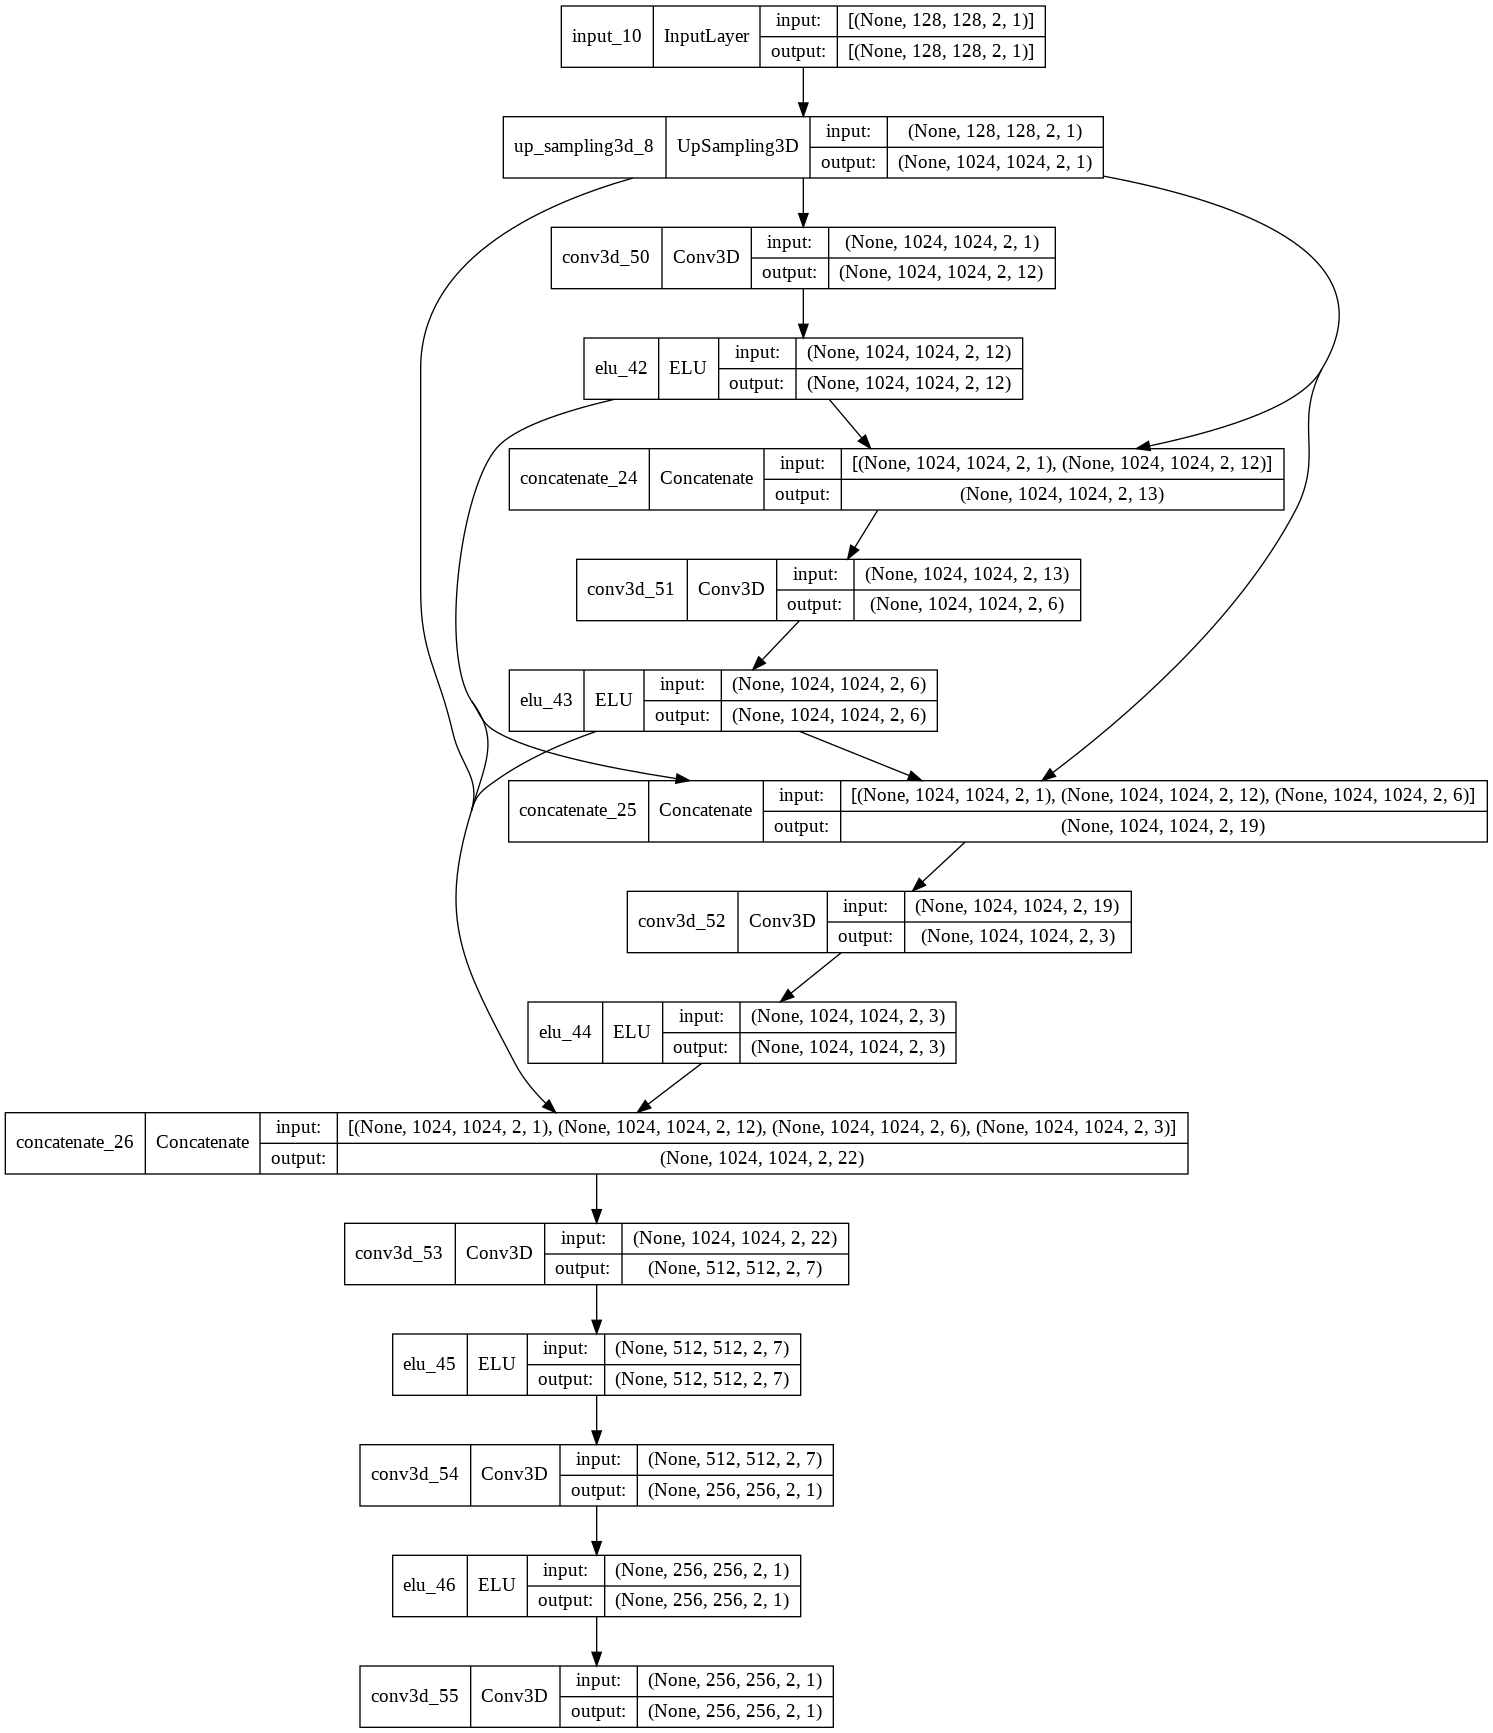

In [ ]:
tfkl = tf.keras.layers

def densenet_superres(
    input_shape=(128,128,4,1),
    initial_filters=8,
    initial_upscaling=2,
    stacks=4,
    filter_scaling=0.25,
    squeezing_stages=3,
    l2=0,
    model_name='densenet_superres'):

    input_tensor = tf.keras.layers.Input(shape=input_shape)

    ups=tf.keras.layers.UpSampling3D(size=(2**initial_upscaling,2**initial_upscaling,1))(input_tensor)
    outputs = [ups]
    x = ups
    for i in range(stacks):
        x = tf.keras.layers.Conv3D(
            filters=initial_filters*filter_scaling**i,
            kernel_size=(3,3,2),
            padding="same",
            kernel_initializer=tfk.initializers.GlorotUniform(),
            kernel_regularizer=tfk.regularizers.l2(l2))(x)

        x = tf.keras.layers.ELU()(x)     
        #x = tf.keras.layers.BatchNormalization()(x)
        stack_output = x
        outputs.append(stack_output)
        x = tfkl.Concatenate()(outputs)

    for j in range(3,initial_upscaling+2):
      x = tf.keras.layers.Conv3D(
          filters=(x.shape[-1])//j,
          kernel_size=(3,3,2),
          padding="same",
          strides=(2,2,1),
          kernel_initializer=tfk.initializers.GlorotUniform(),
          kernel_regularizer=tfk.regularizers.l2(l2))(x)
      x = tf.keras.layers.ELU()(x) 

    x = tf.keras.layers.Conv3D(
          filters=1,
          kernel_size=(3,3,2),
          padding="same",
          kernel_initializer=tfk.initializers.GlorotUniform(),
          kernel_regularizer=tfk.regularizers.l2(l2))(x)

    output_tensor = x
    model = tf.keras.Model(inputs = [input_tensor], 
                              outputs = [output_tensor],name = model_name)
    return model

model = densenet_superres(
    input_shape       = (128,128,2,1),
    initial_upscaling = 3,
    initial_filters   = 12,
    stacks            = 3,
    filter_scaling    = 0.5,
    l2                = 1e-6,
    squeezing_stages  = 3,
    model_name='densenet_superres'
)
print("TRAINABLE PARAMETERS: ","{:e}".format(count_params(model.trainable_weights)))
model.summary()
tf.keras.utils.plot_model(model,rankdir='UD',show_shapes=True)

***

# Training

Defining the functions that calculate the metrics

In [ ]:
from tensorflow.keras import backend as K

# PSNR: Peack Signal-to-Noise Ratio
def psnr(target_data, ref_data):
    return tf.image.psnr(target_data, ref_data, 1)

# SSIM: Structural Similarity Index Measure
def ssim(target_data, ref_data):
    return tf.image.ssim(target_data, ref_data, 1)

# MSLE: Mean Squared Logarithmic Error
def msle(target_data,ref_data):
    return tf.keras.metrics.mean_squared_logarithmic_error(target_data, ref_data)

my_metrics = []
my_metrics.append(msle)
my_metrics.append(psnr)
my_metrics.append(ssim)

This function allows to monitor the progress of the network performance during training: at the end of every epoch, a sample image is tested and the output is displayed. 

In [ ]:
import matplotlib.pyplot as plt
!pip install tensorflow_addons
import tensorflow_addons as tfa
class show_activations(tf.keras.callbacks.Callback):
    def on_epoch_end(self, batch, logs=None):
        plt.figure(figsize=(30,15))
        for p,sl in enumerate([0,6,18]):
            out = self.model.predict(np.expand_dims(testVolumes_slice[sl],0))
            plt.subplot(2,3,p+1)
            plt.imshow(tfa.image.median_filter2d(out[0,:,:,0,0],(2,2)),vmin=0,vmax=1)
            plt.title(f"Predicted")
            plt.subplot(2,3,p+4)
            plt.imshow(testLabels_slice[sl][:,:,0],vmin=0,vmax=1)
            plt.title(f"Expected")
        plt.show()
        del out


In [ ]:
my_loss = 'mse'

my_callbacks = []
my_callbacks.append(show_activations())
my_callbacks.append(
    tf.keras.callbacks.EarlyStopping(
    monitor="val_psnr",
    patience=9,
    mode="max",
    restore_best_weights=True)
)
my_callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
        "checkpoint_{epoch:02d}.h5",
        monitor="val_loss",
        save_best_only=False,
        save_weights_only=False,
        mode="min",
    )
)

# Learning-rate scheduler. LR is halved every 3 epochs
def lrscheduler(epochs,lr):
    if epochs%3==0: return lr/2
    else: return lr

my_callbacks.append(tfk.callbacks.LearningRateScheduler(lrscheduler))
my_callbacks.append(
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_psnr",
        factor=0.1,
        patience=5,
        verbose=1,
        mode="max"
    ),
)

LEARNING_RATE = 1e-3
BATCH_SIZE = 2
MAX_EPOCHS = 50

model.compile(
    optimizer = tf.keras.optimizers.Adam(LEARNING_RATE),
    loss      = my_loss,
    metrics   = my_metrics 
    )

monitoring = model.fit(
    x = trainVolumes_slice, 
    y = trainLabels_slice, 
    batch_size = BATCH_SIZE, 
    epochs = MAX_EPOCHS, 
    validation_data = (
        validationVolumes_slice,
        validationLabels_slice
    ),
    callbacks = my_callbacks) 

# Save the net
model.save("./model_fulltrained.h5")

Visual inspection of some of the test images

In [ ]:
for case in range(len(testVolumes_slice)//3):
    print(f"Evaluating Test case #{case+1}")
    prediction = model.predict(np.expand_dims(testVolumes_slice[case],0))
    #print(f"PSNR={psnr(testLabels_slice[case].astype('float32'), prediction.astype('float32'))} - SSIM={ssim(testLabels_slice[case, :, :, :].astype('float32'), prediction[0,:, :, :].astype('float32'))}")
    for i in range(0, 2):
        fig = plt.figure(figsize = (25,17))
        plt.subplot(1, 3, 1)
        plt.imshow(testVolumes_slice[case, :, :, i], cmap = 'gray')
        plt.title("Original 128x128x64")
        plt.subplot(1, 3, 2)
        plt.imshow(testLabels_slice[case, :, :, i], cmap = 'gray')
        plt.title("Expected 256x256x64")
        plt.subplot(1, 3, 3)
        plt.imshow(prediction[0,:, :,i,0], cmap = 'gray')
        plt.title(f"Predicted 256x256x64")
        plt.show(fig)

Output hidden; open in https://colab.research.google.com to view.